In [1]:
import matplotlib as mpl
from Datasets import * 

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
from LiteModels import DeepLite
from Datasets import *

from MMD.mmd import MMD_3_Sample_Test
import h5py as h5
from tqdm import trange
from scipy.misc import imresize
import seaborn as sns
import pandas as pd

%matplotlib inline

In [21]:
m1 = -1
m2 = 1
s1 = 0.2
s2 = 1.0

seed=12
np.random.seed(seed)

N = 100000
alpha = 0.5
D = 1
d1 = np.random.randn(int(N*alpha), D)*s1 + m1
d2 = np.random.randn(int(N*(1-alpha)), D)*s2 + m2
true_pdf = lambda x: alpha * norm.pdf(x,loc=m1, scale=s1) + (1-alpha)*norm.pdf(x, loc=m2, scale=s2)

p = ArrayDataset(np.concatenate([d1,d2],0), "MOG", ntest=300, whiten=False, itanh=False)


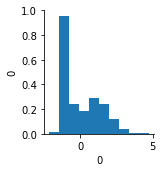

In [22]:
# visualise data
df = pd.DataFrame(p.sample(1000))
sns.pairplot(df,plot_kws=dict(s=4, alpha=1.0, linewidth=0))

manually change LiteNet to set lambdas

In [40]:
gaussian_lite = DeepLite(p, npoint=300, nlayer=0, nneuron=10, init_log_lam=-1, points_std=0.0, keep_prob=1.0, init_weight_std=1.0, noise_std=0.0,
                    points_type="fixed", log_lam_weights=-6, step_size=1e-2, mixture_kernel=False, init_log_sigma=np.linspace(0,1,1), base=False,
                    niter=500, ntrain=300, nvalid=200, patience=30,gpu_count=1, seed=seed)
res = gaussian_lite.fit(niter=1000, ntrain=300, nvalid=300,ntest=300, nbatch=1, patience=30)

trainining kernel: 100%|██| 1001/1001 [01:19<00:00, 14.74it/s[{'test': '-5.716', 'loss': '-5.195'}]]

INFO:tensorflow:Restoring parameters from ckpts/M_D01_l0_nd0_np300_nt300_nv300_ptf_ss100_ni500_n00_k10_m0_b0_p30_nk1_c0_s12.ckpt


best score: -5.71552


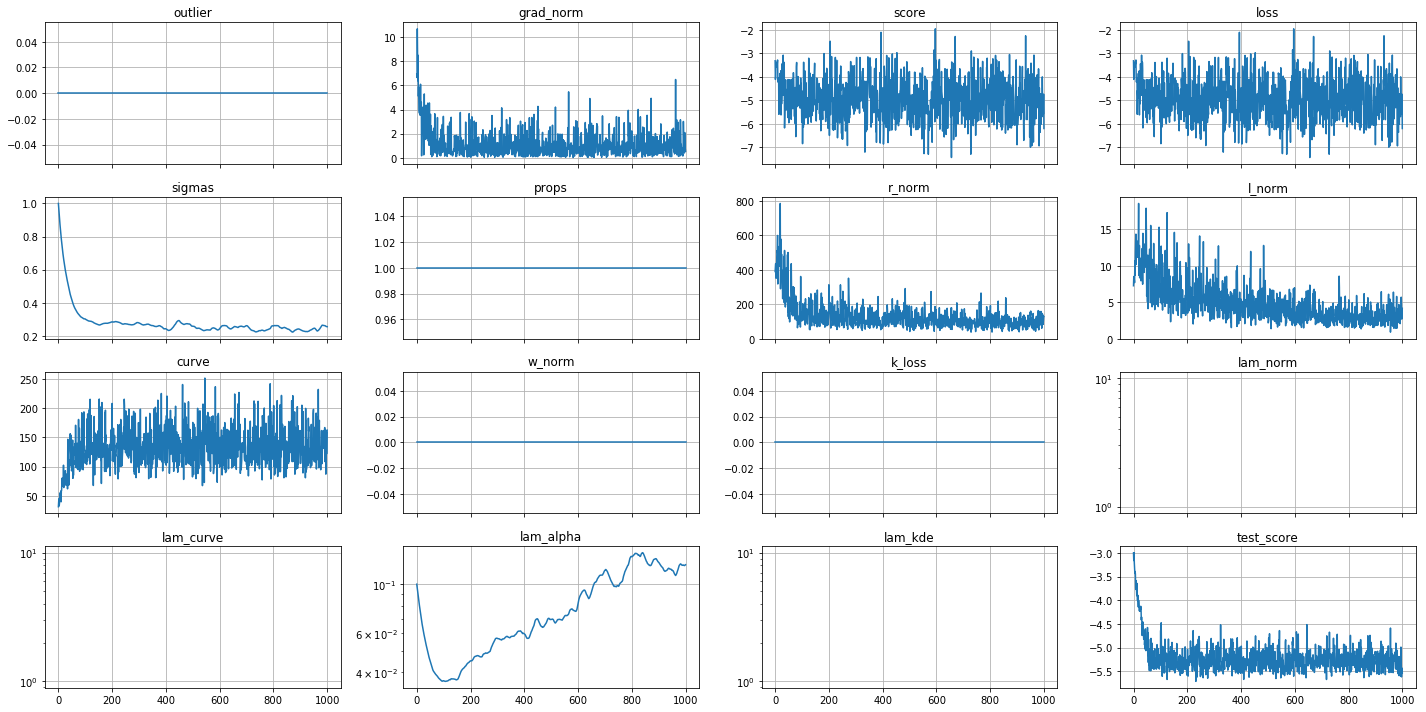

In [41]:
fig, axes = plt.subplots(4,4,figsize=(20,10), sharex=True)

axes = axes.flatten()
res = gaussian_lite.state_hist

for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        
        ax.set_yscale("log")
    ax.grid("on")
    
        
fig.tight_layout()

In [57]:
deep_lite = DeepLite(p, npoint=300, nlayer=3, nneuron=20, init_log_lam=-1, points_std=0.0, keep_prob=1.0, init_weight_std=1.0, noise_std=0.0,
                    points_type="fixed", log_lam_weights=-6, step_size=1e-2, mixture_kernel=False, init_log_sigma=np.linspace(0,1,1), base=False,
                    niter=1000, ntrain=300, nvalid=300, patience=50,gpu_count=1, seed=seed)
res = deep_lite.fit(niter=1000, ntrain=300, nvalid=300,ntest=300, nbatch=1, patience=30)

trainining kernel: 100%|██| 1001/1001 [04:19<00:00,  4.30it/s[{'test': '-5.820', 'loss': '-5.043'}]]


INFO:tensorflow:Restoring parameters from ckpts/M_D01_l3_nd20_np300_nt300_nv300_ptf_ss100_ni1000_n00_k10_m0_b0_p30_nk1_c0_s12.ckpt
best score: -5.82049


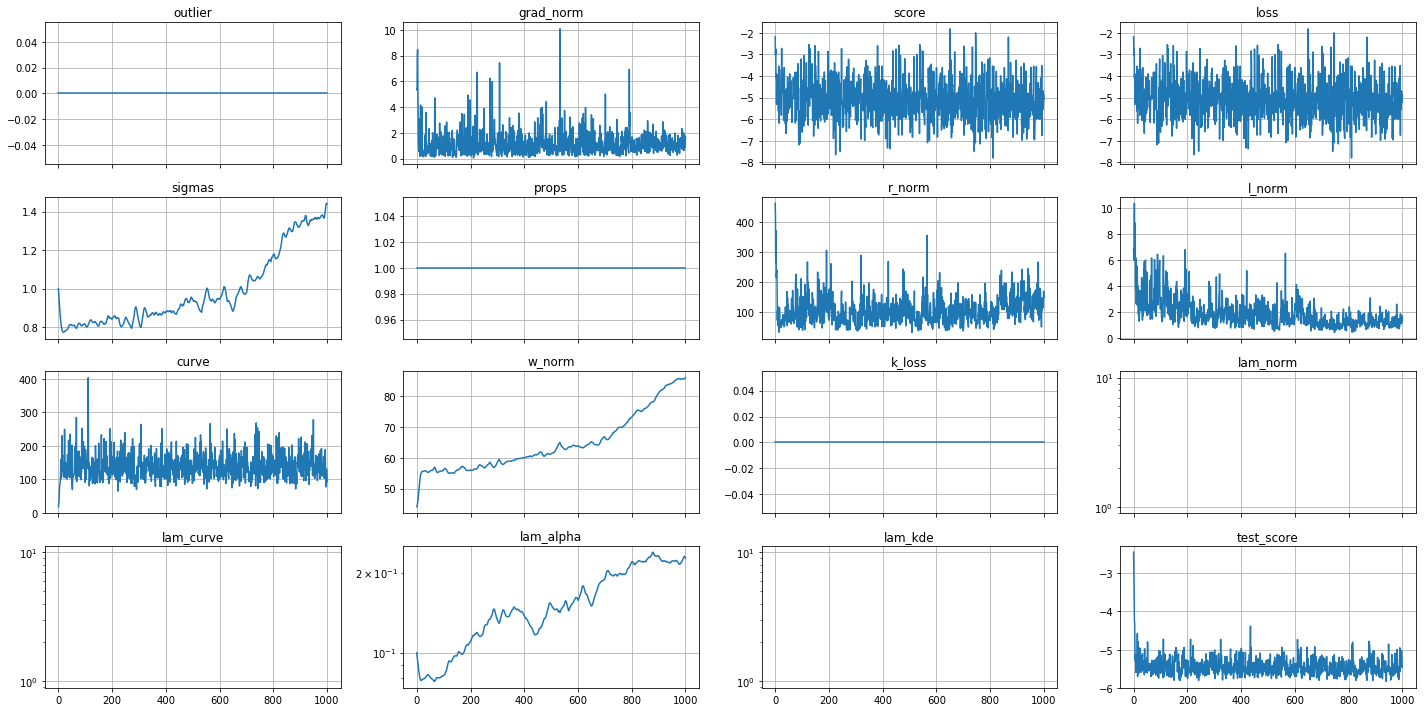

In [58]:
fig, axes = plt.subplots(4,4,figsize=(20,10), sharex=True)

axes = axes.flatten()
res = deep_lite.state_hist

for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        ax.set_yscale("log")
    ax.grid("on")
        
fig.tight_layout()

In [50]:
# final fit of alphas. Better do it on cpu so have to redefine the model (set True) and tell it gpu_count = 0
gaussian_lite.set_test(True, 0)
gaussian_lite.fit_alpha(5000)

INFO:tensorflow:Restoring parameters from ckpts/M_D01_l0_nd0_np300_nt300_nv300_ptf_ss100_ni500_n00_k10_m0_b0_p30_nk1_c0_s12.ckpt


In [59]:
deep_lite.set_test(True, 0) 
deep_lite.fit_alpha(5000)

INFO:tensorflow:Restoring parameters from ckpts/M_D01_l3_nd20_np300_nt300_nv300_ptf_ss100_ni1000_n00_k10_m0_b0_p30_nk1_c0_s12.ckpt


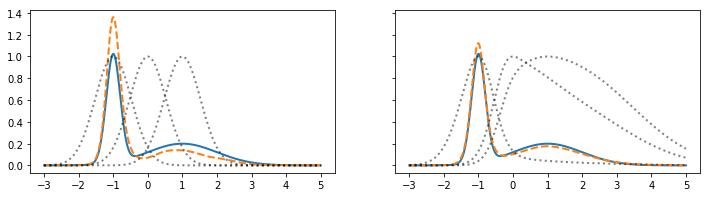

In [60]:
ngrid = 1000
eval_grid = np.linspace(-3,5,ngrid)
grid_points = np.linspace(-1,1,3)[:,None]
grid_data   = eval_grid[:,None]


fig, axes = plt.subplots(1,2,figsize=(12,3), sharex=True, sharey=True)

true_density = true_pdf(eval_grid)
true_density /= sum(true_density) * (eval_grid[1]-eval_grid[0])
ax = axes[0]
ax.plot(eval_grid, true_density, label="true pdf", lw=2)

fv = gaussian_lite.fun_multiple(eval_grid[:,None])
density = np.exp(fv)
density /= np.sum(density) * (eval_grid[1]-eval_grid[0])
ax.plot(eval_grid, density, label="Gaussian lite", lw=2, ls="--")

kernel_vals = gaussian_lite.sess.run(gaussian_lite.ops["kernel_grams"][0], feed_dict={gaussian_lite.test_points: grid_points, gaussian_lite.test_data: grid_data})
ax.plot(eval_grid.T, kernel_vals[1:].T, "k:", lw=2, alpha=0.5) 
ax.plot(eval_grid.T, kernel_vals[0], "k:", label="deep kernel", lw=2, alpha=0.5)

ax = axes[1]
ax.plot(eval_grid, true_density, label="true pdf", lw=2)
fv = deep_lite.fun_multiple(eval_grid[:,None])
density = np.exp(fv)
density /= np.sum(density) * (eval_grid[1]-eval_grid[0])
ax.plot(eval_grid, density, label="", lw=2, ls="--")



kernel_vals = deep_lite.sess.run(deep_lite.ops["kernel_grams"][0], feed_dict={deep_lite.test_points: grid_points, deep_lite.test_data: grid_data})
ax.plot(eval_grid.T, kernel_vals[1:].T, "k:", lw=2, alpha=0.5) 
ax.plot(eval_grid.T, kernel_vals[0], "k:", label="deep kernel", lw=2, alpha=0.5)

#plt.savefig("figs/MoG_scales.pdf")

In [61]:

from maf import experiments as ex

n_hiddens = 10
n_layers = 5
n_comps = 10

act_fun = 'tanh'
mode = 'random'

maf_data_obj = ex.load_data("array", data_array=p.data, whiten=False)
maf_model = ex.train_maf_on_made([n_hiddens]*2, act_fun, n_layers, n_comps, mode)

In [62]:
maf_log_pdf = maf_model.eval(eval_grid[:,None])

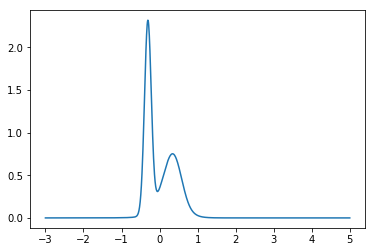

In [63]:
plt.plot(eval_grid, np.exp(maf_log_pdf))

In [64]:
maf_model.gen(1000).std()

0.37826279

(array([   1.,   87.,  391.,   79.,  117.,  171.,  109.,   31.,   12.,    2.]),
 array([-0.806, -0.597, -0.388, -0.18 ,  0.029,  0.238,  0.447,  0.656,  0.865,  1.074,  1.283]),
 <a list of 10 Patch objects>)

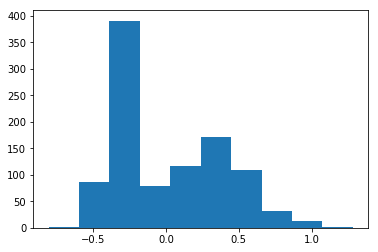

In [68]:
plt.hist(maf_data_obj.tst.x[:,0])